In [ ]:
# Блок 0: базовые импорты и подключение диска

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path

# Подключаем Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Путь к папке с данными на диске (ИЗМЕНИ под себя при необходимости)
DATA_DIR = Path("/content/drive/MyDrive/AlfaBand_HACK")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Блок 1: загрузка данных

train_path = DATA_DIR / "hackathon_income_train.csv"
test_path = DATA_DIR / "hackathon_income_test.csv"
feat_desc_path = DATA_DIR / "features_description.csv"

train = pd.read_csv(
    train_path,
    sep=";",                 # разделитель — точка с запятой
    engine="python",         # более терпимый парсер
    on_bad_lines="warn",     # если есть реально битые строки — покажет предупреждение и пропустит
    na_values=["None", "nan"]  # эти строки превращаем в NaN
)

test = pd.read_csv(
    test_path,
    sep=";",
    engine="python",
    on_bad_lines="warn",
    na_values=["None", "nan"]
)

feat_desc = pd.read_csv(
    feat_desc_path,
    sep=";",
    engine="python",
    encoding="windows-1251"   # или "windows-1251"
)


print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Features description shape:", feat_desc.shape)

"""# 1. Разбор данных и признаков (типы, target, w, num/cat features)"""

Train shape: (76786, 224)
Test shape: (73214, 222)
Features description shape: (224, 2)


'# 1. Разбор данных и признаков (типы, target, w, num/cat features)'

In [ ]:
# Блок 2: общая структура данных

print("Первые строки train:")
display(train.head())

print("\nИнформация о train:")
print(train.info())

print("\nПервые строки test:")
display(test.head())

print("\nПервые строки features_description:")
display(feat_desc.head())
print("\nКолонки в features_description:", feat_desc.columns.tolist())

# Блок 3: сравнение признаков train и test

train_cols = set(train.columns)
test_cols = set(test.columns)

only_in_train = train_cols - test_cols
only_in_test = test_cols - train_cols

print("Только в train:", only_in_train)
print("Только в test:", only_in_test)

# Блок 4: просмотр списка колонок

print("Колонки train:")
for i, col in enumerate(train.columns):
    print(i, col, "->", train[col].dtype)

# Блок 5: служебные колонки

ID_COL = "id"
TARGET_COL = "target"
WEIGHT_COL = "w"  # вес наблюдения для WMAE

for col in [ID_COL, TARGET_COL, WEIGHT_COL]:
    assert col in train.columns, f"Колонка {col} не найдена в train!"

print("ID колонка:", ID_COL)
print("Таргет:", TARGET_COL)
print("Вес:", WEIGHT_COL)

print("\nТипы этих колонок в train:")
print(train[[ID_COL, TARGET_COL, WEIGHT_COL]].dtypes)

# Блок 6: приведение target и w к числу

def to_numeric_series(s: pd.Series) -> pd.Series:
    # На случай, если в числах запятая или пробелы
    return pd.to_numeric(
        s.astype(str).str.replace(",", ".", regex=False).str.replace(" ", "", regex=False),
        errors="coerce"
    )

# Приводим target
train[TARGET_COL] = to_numeric_series(train[TARGET_COL])

# Приводим w (если он не float)
train[WEIGHT_COL] = to_numeric_series(train[WEIGHT_COL])

print(train[[TARGET_COL, WEIGHT_COL]].dtypes)
print("\nОписательная статистика по таргету:")
display(train[TARGET_COL].describe())

# Блок 7: авто-детект числовых колонок среди object

import re

def detect_numeric_like_object_cols(df: pd.DataFrame, sample_frac: float = 0.2, thresh: float = 0.9):
    """
    Ищем object-колонки, которые на самом деле числовые:
    берем случайную подвыборку, проверяем долю "похожих на число" строк.
    """
    obj_cols = df.select_dtypes(include="object").columns.tolist()
    numeric_like = []

    for col in obj_cols:
        # Пропускаем явно категориальные по смыслу, если хочешь
        # (сюда можно руками добавить что-то вроде 'gender', 'city_smart_name' и т.д.)
        # например:
        # if col in ["gender", "adminarea", "city_smart_name", ...]:
        #     continue

        s = df[col].dropna()
        if s.empty:
            continue

        s = s.sample(frac=sample_frac, random_state=42) if len(s) > 5000 else s

        # Нормализуем: заменяем запятую на точку, убираем пробелы
        s_norm = s.astype(str).str.replace(",", ".", regex=False).str.replace(" ", "", regex=False)

        # Проверяем, похоже ли это на число: допустим -12.34
        mask_num = s_norm.str.match(r"^-?\d+(\.\d+)?$", na=False)

        share_numeric = mask_num.mean()

        if share_numeric >= thresh:
            numeric_like.append(col)

    return numeric_like

numeric_like_cols = detect_numeric_like_object_cols(train.drop(columns=[TARGET_COL]))  # таргет уже числовой

print("Колонок, похожих на числовые (хотя сейчас object):", len(numeric_like_cols))
print(numeric_like_cols[:30])  # первые 30 для примера


Первые строки train:


,id,dt,target,turn_cur_cr_avg_act_v2,salary_6to12m_avg,hdb_bki_total_max_limit,dp_ils_paymentssum_avg_12m,hdb_bki_total_cc_max_limit,incomeValue,gender,...,dp_ils_uniq_companies_1y,avg_6m_travel,avg_6m_government_services,hdb_bki_active_cc_max_overdue,total_rur_amt_cm_avg_period_days_ago_v2,label_Above_1M_share_r1,transaction_category_supermarket_sum_cnt_d15,max_balance_rur_amt_1m_af,w,first_salary_income
0,2,2024-04-30,"109324,47632478633","1465144,96",NaN,52800.0,"365346,244633755",23213.0,"97366,0",Женский,...,"1,0","0,0","57,0",0.0,"297,0","0,02702702702702703","9,0",NaN,"0,3012172807640372",NaN
1,4,2024-02-29,"25558,02866242038","303593,66",NaN,260200.0,NaN,10000.0,"32580,0",Женский,...,NaN,"0,0","707,0",67.0,"30245,0",NaN,"2,0",NaN,"0,6957996079578388",NaN
2,5,2024-02-29,"40666,753097982706","490754,01",NaN,2000000.0,NaN,90000.0,"96866,0",Женский,...,NaN,"422,0","0,0",0.0,"210322,0","0,0","20,0",NaN,"0,5159704060557002",NaN
3,6,2024-04-30,"43856,67205839414","219875,12",NaN,75000.0,NaN,75000.0,"43860,0",Мужской,...,NaN,"0,0","0,0",0.0,"7187,0","0,0","7,0",NaN,"0,4780029003784456",NaN
4,7,2024-04-30,"130420,85199232883","1750241,8449999997",NaN,1000000.0,NaN,240000.0,"83815,0",Женский,...,NaN,"0,0","84,0",0.0,"690038,0","0,0","9,0",NaN,"0,5523135540134384",NaN



Информация о train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76786 entries, 0 to 76785
Columns: 224 entries, id to first_salary_income
dtypes: float64(34), int64(1), object(189)
memory usage: 131.2+ MB
None

Первые строки test:


,id,dt,turn_cur_cr_avg_act_v2,salary_6to12m_avg,hdb_bki_total_max_limit,dp_ils_paymentssum_avg_12m,hdb_bki_total_cc_max_limit,incomeValue,gender,avg_cur_cr_turn,...,total_sum,dp_ils_uniq_companies_1y,avg_6m_travel,avg_6m_government_services,hdb_bki_active_cc_max_overdue,total_rur_amt_cm_avg_period_days_ago_v2,label_Above_1M_share_r1,transaction_category_supermarket_sum_cnt_d15,max_balance_rur_amt_1m_af,first_salary_income
0,0,2024-08-31,"805319,38",NaN,61137.47,NaN,60000.0,"159999,0",Женский,"69740,0",...,NaN,NaN,"0,0","0,0",NaN,"80228,0","0,0","1,0",NaN,NaN
1,1,2024-10-31,"306240,0",NaN,949500.00,NaN,230000.0,"108834,0",Мужской,"63513,0",...,"0,0",NaN,"0,0","0,0",0.0,"24888,0","0,0",NaN,NaN,NaN
2,3,2024-09-30,"164908,72999999998",NaN,178000.00,NaN,178000.0,"59203,0",Женский,"132,0",...,"38630,630000000005",NaN,"0,0","0,0",2363.9,"223,0",NaN,NaN,NaN,NaN
3,9,2024-10-31,"2374846,42",NaN,25500.00,"126247,44835851202",4999.0,"180906,0",Женский,"290339,0",...,NaN,"3,0","800,0","0,0",NaN,"25734,0","0,0","7,0","0,0",NaN
4,11,2024-11-30,"735902,71","47828,145620567375",60000.00,NaN,60000.0,"24922,0",Мужской,"76924,0",...,"0,0",NaN,"0,0","0,0",0.0,"1214,0","0,0","15,0",NaN,NaN



Первые строки features_description:


,признак,описание
0,dt,Дата актуальности признаков
1,target,таргет
2,turn_cur_cr_avg_act_v2,Средний текущий кредитовый оборот по текущим с...
3,salary_6to12m_avg,Усреднённая ЗП клиента за окно в минимум 6 мес...
4,hdb_bki_total_max_limit,БКИ: Максимальный кредитный лимит по любому пр...



Колонки в features_description: ['признак', 'описание']
Только в train: {'target', 'w'}
Только в test: set()
Колонки train:
0 id -> int64
1 dt -> object
2 target -> object
3 turn_cur_cr_avg_act_v2 -> object
4 salary_6to12m_avg -> object
5 hdb_bki_total_max_limit -> float64
6 dp_ils_paymentssum_avg_12m -> object
7 hdb_bki_total_cc_max_limit -> float64
8 incomeValue -> object
9 gender -> object
10 avg_cur_cr_turn -> object
11 adminarea -> object
12 turn_cur_cr_avg_v2 -> object
13 turn_cur_cr_max_v2 -> object
14 hdb_bki_total_pil_max_limit -> float64
15 age -> object
16 dp_ils_avg_salary_1y -> object
17 turn_cur_cr_sum_v2 -> object
18 by_category__amount__sum__eoperation_type_name__ishodjaschij_bystryj_platezh_sbp -> object
19 turn_cur_db_sum_v2 -> object
20 turn_cur_db_avg_act_v2 -> object
21 dp_ils_avg_salary_2y -> object
22 curr_rur_amt_cm_avg -> object
23 turn_cur_db_avg_v2 -> object
24 by_category__amount__sum__eoperation_type_name__vhodjaschij_bystryj_platezh_sbp -> object
25 dp_il

,target
count,7.678600e+04
mean,9.264824e+04
std,1.124090e+05
min,2.000000e+04
25%,3.970997e+04
50%,6.275413e+04
75%,1.002017e+05
max,1.500000e+06


Колонок, похожих на числовые (хотя сейчас object): 180
['turn_cur_cr_avg_act_v2', 'salary_6to12m_avg', 'dp_ils_paymentssum_avg_12m', 'incomeValue', 'avg_cur_cr_turn', 'turn_cur_cr_avg_v2', 'turn_cur_cr_max_v2', 'age', 'dp_ils_avg_salary_1y', 'turn_cur_cr_sum_v2', 'by_category__amount__sum__eoperation_type_name__ishodjaschij_bystryj_platezh_sbp', 'turn_cur_db_sum_v2', 'turn_cur_db_avg_act_v2', 'dp_ils_avg_salary_2y', 'curr_rur_amt_cm_avg', 'turn_cur_db_avg_v2', 'by_category__amount__sum__eoperation_type_name__vhodjaschij_bystryj_platezh_sbp', 'dp_ils_paymentssum_avg_6m', 'avg_cur_db_turn', 'incomeValueCategory', 'avg_by_category__amount__sum__cashflowcategory_name__vydacha_nalichnyh_v_bankomate', 'avg_credit_turn_rur', 'dp_ils_salary_ratio_1y3y', 'by_category__amount__sum__eoperation_type_name__perevod_po_nomeru_telefona', 'turn_cur_cr_7avg_avg_v2', 'dp_ils_accpayment_avg_12m', 'curbal_usd_amt_cm_avg', 'avg_by_category__amount__sum__cashflowcategory_name__supermarkety', 'avg_loan_cnt_wi

In [ ]:
# Блок 8: конвертация numeric-like object колонок в float в train и test

def convert_cols_to_numeric(df: pd.DataFrame, cols):
    for col in cols:
        df[col] = to_numeric_series(df[col])

convert_cols_to_numeric(train, numeric_like_cols)
convert_cols_to_numeric(test, numeric_like_cols)

print("Проверим типы для первых нескольких колонок из numeric_like_cols:")
for c in numeric_like_cols[:20]:
    print(c, "->", train[c].dtype)

# Блок 9: формируем списки признаков

service_cols = [ID_COL, TARGET_COL, WEIGHT_COL]

# Все фичи = все колонки, кроме служебных
feature_cols = [c for c in train.columns if c not in service_cols]
print("Всего признаков (без id, target, w):", len(feature_cols))

# Числовые фичи (после конвертации)
num_features = train[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

# Категориальные фичи = всё остальное
cat_features = [c for c in feature_cols if c not in num_features]

print("Числовые признаки:", len(num_features))
print("Категориальные признаки:", len(cat_features))

print("\nПример числовых признаков:")
print(num_features[:20])

print("\nПример категориальных признаков:")
print(cat_features[:20])

# Все категориальные признаки, первые 5 строк
train[cat_features].head()

train["period_last_act_ad"].unique()

"""# 2. Extensive EDA (все EDA-блоки)"""

Проверим типы для первых нескольких колонок из numeric_like_cols:
turn_cur_cr_avg_act_v2 -> float64
salary_6to12m_avg -> float64
dp_ils_paymentssum_avg_12m -> float64
incomeValue -> float64
avg_cur_cr_turn -> float64
turn_cur_cr_avg_v2 -> float64
turn_cur_cr_max_v2 -> float64
age -> float64
dp_ils_avg_salary_1y -> float64
turn_cur_cr_sum_v2 -> float64
by_category__amount__sum__eoperation_type_name__ishodjaschij_bystryj_platezh_sbp -> float64
turn_cur_db_sum_v2 -> float64
turn_cur_db_avg_act_v2 -> float64
dp_ils_avg_salary_2y -> float64
curr_rur_amt_cm_avg -> float64
turn_cur_db_avg_v2 -> float64
by_category__amount__sum__eoperation_type_name__vhodjaschij_bystryj_platezh_sbp -> float64
dp_ils_paymentssum_avg_6m -> float64
avg_cur_db_turn -> float64
incomeValueCategory -> float64
Всего признаков (без id, target, w): 221
Числовые признаки: 214
Категориальные признаки: 7

Пример числовых признаков:
['turn_cur_cr_avg_act_v2', 'salary_6to12m_avg', 'hdb_bki_total_max_limit', 'dp_ils_paymentss

'# 2. Extensive EDA (все EDA-блоки)'

Train shape: (76786, 224)
Test shape: (73214, 222)

Типы колонок (train):


,count
float64,216
object,7
int64,1



Числовые признаки: 214
Категориальные признаки: 7
TOP-30 признаков по доле пропусков в train:


,0
avg_by_category__amount__sum__cashflowcategory_name__platezhi_cherez_internet,0.984411
turn_fdep_db_avg_act_v2,0.969721
turn_fdep_db_avg_v2,0.950043
turn_fdep_db_sum_v2,0.950043
avg_by_category__amount__sum__cashflowcategory_name__reklama_v_internete,0.931993
avg_by_category__amount__sum__cashflowcategory_name__zarubezhnye_finansovye_operatsii,0.927487
dp_payoutincomedata_payout_avg_prev_year,0.897494
first_salary_income,0.887115
avg_by_category__amount__sum__cashflowcategory_name__oteli,0.884601
by_category__amount__sum__eoperation_type_name__perevod_s_karty_na_kartu,0.881671



TOP-30 признаков по доле пропусков в test:


,0
first_salary_income,1.000000
avg_by_category__amount__sum__cashflowcategory_name__platezhi_cherez_internet,0.984033
avg_by_category__amount__sum__cashflowcategory_name__zarubezhnye_finansovye_operatsii,0.953137
turn_fdep_db_avg_act_v2,0.951007
avg_by_category__amount__sum__cashflowcategory_name__reklama_v_internete,0.939602
turn_fdep_db_avg_v2,0.931707
turn_fdep_db_sum_v2,0.931707
loan_cur_amt,0.923908
salary_6to12m_avg,0.895730
avg_by_category__amount__sum__cashflowcategory_name__oteli,0.880720


/tmp/ipython-input-2435343980.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


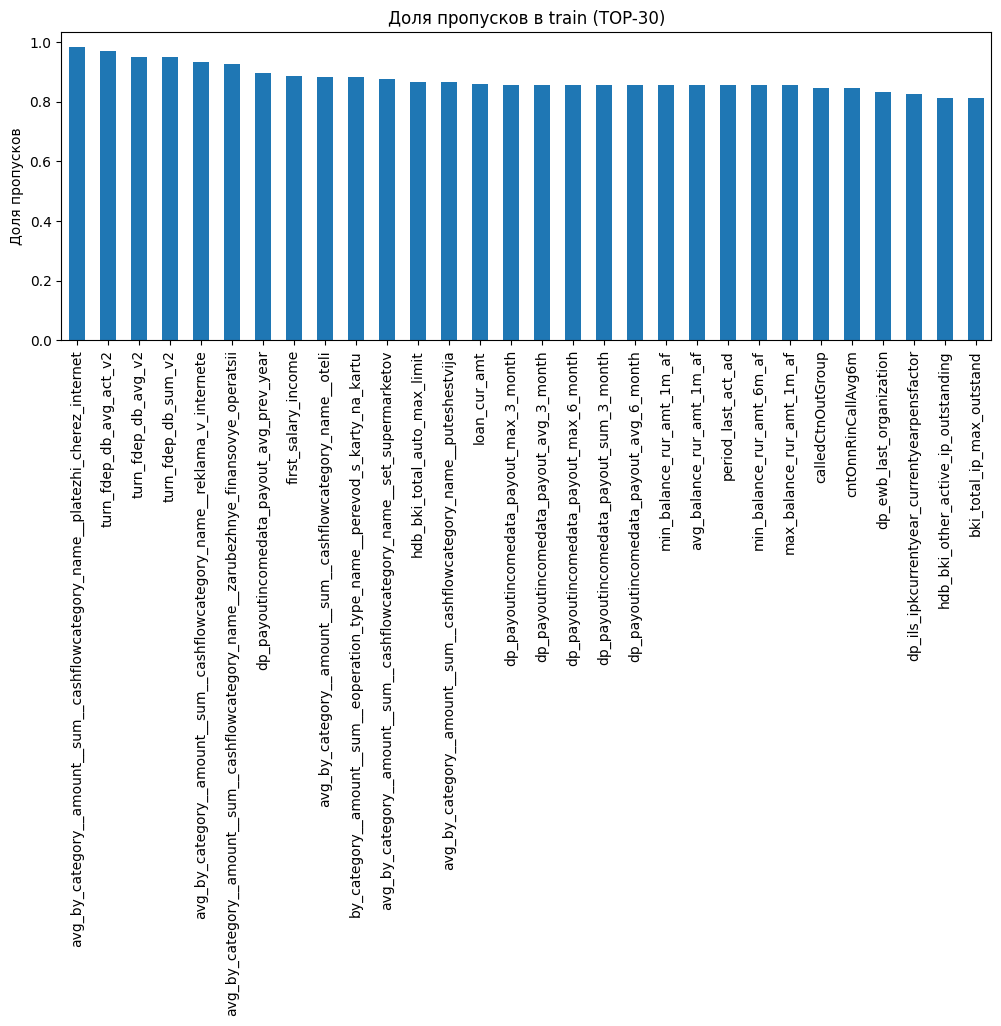

Будем удалить признаков с очень высокой долей пропусков: 2
['avg_by_category__amount__sum__cashflowcategory_name__platezhi_cherez_internet', 'first_salary_income']

Train shape после удаления: (76786, 222)
Test shape после удаления: (73214, 220)

После дропа признаков с высоким NaN:
Всего фичей: 219
Числовых фичей: 212
Категориальных фичей: 7


,count,mean,std,min,1%,5%,50%,95%,99%,max
turn_cur_cr_avg_act_v2,59078.0,1.170105e+06,2.205263e+06,0.010000,100.000000,2300.000000,594020.437500,4.094268e+06,1.048292e+07,6.545863e+07
salary_6to12m_avg,14875.0,1.174897e+05,1.603782e+05,20003.739558,21769.843659,26796.156284,73092.407991,3.416337e+05,8.629996e+05,3.419392e+06
hdb_bki_total_max_limit,67413.0,1.353383e+06,2.261767e+06,0.000000,5000.000000,29300.000000,577200.000000,5.100000e+06,1.000176e+07,1.500000e+08
dp_ils_paymentssum_avg_12m,16503.0,2.162228e+05,2.538178e+05,2.648938,18562.015347,43942.278892,149711.981885,6.112565e+05,1.240706e+06,4.754632e+06
hdb_bki_total_cc_max_limit,63041.0,2.504806e+05,3.471460e+05,0.000000,0.000000,1500.000000,155000.000000,8.000000e+05,1.500000e+06,1.500000e+07
incomeValue,63817.0,8.168234e+04,5.130698e+04,0.000000,22027.000000,29345.000000,67474.000000,1.834088e+05,2.662666e+05,5.420840e+05
avg_cur_cr_turn,60214.0,1.866825e+05,4.615432e+05,0.000000,0.000000,0.000000,74361.500000,7.007000e+05,2.028762e+06,1.702021e+07
turn_cur_cr_avg_v2,59432.0,1.601873e+05,3.500297e+05,0.000000,2.500000,150.000000,67695.515833,5.925260e+05,1.648449e+06,1.328000e+07
turn_cur_cr_max_v2,59432.0,3.200456e+05,8.496348e+05,0.000000,25.000000,1138.964500,90000.000000,1.339445e+06,3.742918e+06,2.961870e+07
hdb_bki_total_pil_max_limit,62001.0,6.067355e+05,9.167729e+05,0.000000,5000.000000,19738.000000,338977.500000,2.017937e+06,4.330500e+06,3.900000e+07


Всего числовых признаков в summary: 212
Сводка по числовым признакам сохранена в: /content/drive/MyDrive/AlfaBand_HACK/num_features_summary.csv
Описательная статистика по таргету:


,target
count,7.678600e+04
mean,9.264824e+04
std,1.124090e+05
min,2.000000e+04
1%,2.040658e+04
5%,2.271157e+04
50%,6.275413e+04
95%,2.560746e+05
99%,5.965851e+05
max,1.500000e+06


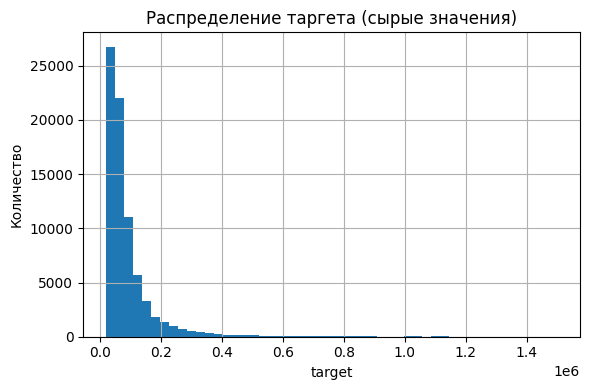

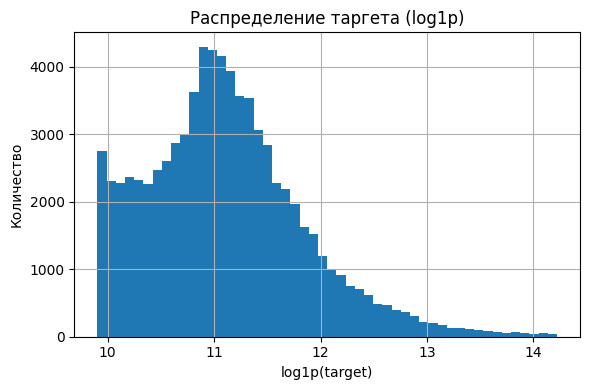

TOP-30 признаков по |corr| с таргетом:


,target
salary_6to12m_avg,0.927699
dp_payoutincomedata_payout_avg_6_month,0.672173
dp_payoutincomedata_payout_avg_3_month,0.644840
dp_payoutincomedata_payout_sum_3_month,0.644542
turn_cur_db_avg_act_v2,0.640399
turn_cur_cr_avg_act_v2,0.638592
dp_payoutincomedata_payout_avg_prev_year,0.630530
turn_cur_cr_sum_v2,0.630285
turn_cur_cr_avg_v2,0.630285
turn_cur_db_sum_v2,0.628880


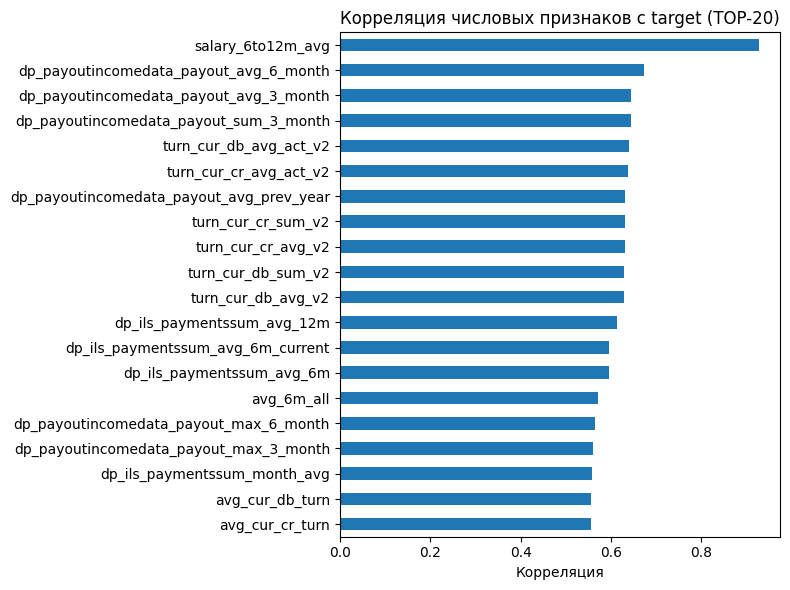


=== gender ===


,count,mean,median
gender,,,
Мужской,40121,106700.581424,71513.320826
Женский,36665,77271.348093,55134.307987


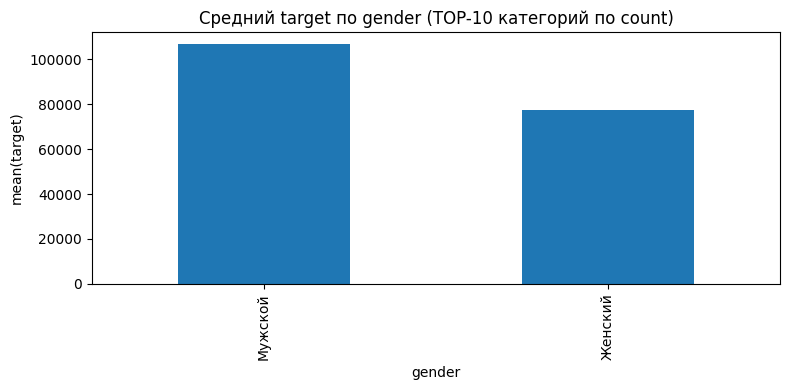


=== city_smart_name ===


,count,mean,median
city_smart_name,,,
Москва,23230,118297.195757,74778.308573
Санкт-Петербург,4843,97183.287313,69134.710000
Екатеринбург,2439,88889.679561,60038.870000
Краснодар,1786,83338.207468,58918.642316
Новосибирск,1366,84178.040378,58062.314130
Самара,1275,77889.785514,56931.960985
Красноярск,1267,79552.286984,55984.291200
Омск,1266,76543.237085,55379.913361
Челябинск,1177,76531.642963,57266.540000


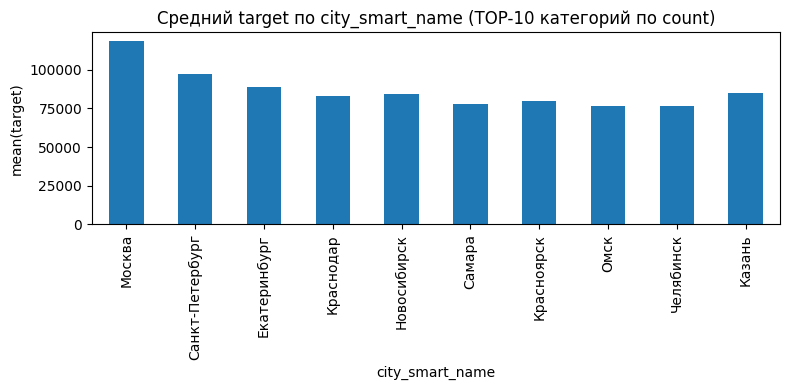

In [ ]:
# Блок EDA-1: общая инфа по датасетам

print("Train shape:", train.shape)
print("Test shape:", test.shape)

print("\nТипы колонок (train):")
display(train.dtypes.value_counts())

print("\nЧисловые признаки:", len(num_features))
print("Категориальные признаки:", len(cat_features))

# Блок EDA-2: пропуски в train и test

missing_train = train.isna().mean().sort_values(ascending=False)
missing_test = test.isna().mean().sort_values(ascending=False)

print("TOP-30 признаков по доле пропусков в train:")
display(missing_train.head(30))

print("\nTOP-30 признаков по доле пропусков в test:")
display(missing_test.head(30))

# Визуализация пропусков для train (TOP-30)
top_n = 30
plt.figure(figsize=(12, 4))
missing_train.head(top_n).plot(kind="bar")
plt.title(f"Доля пропусков в train (TOP-{top_n})")
plt.ylabel("Доля пропусков")
plt.tight_layout()
plt.show()

# Блок M1: удаляем признаки с очень высокой долей пропусков

# служебные колонки
service_cols = [ID_COL, TARGET_COL, WEIGHT_COL]

# фичи до чистки
raw_feature_cols = [c for c in train.columns if c not in service_cols]

na_train = train[raw_feature_cols].isna().mean()
na_test  = test[raw_feature_cols].isna().mean()

# порог "почти всё NaN" — можно подправить (0.95 / 0.97 и т.п.)
THRESH_HIGH_NA = 0.97

# 1) признаки, где доля NaN > порога и в train, и в test
high_na_both = na_train.index[(na_train > THRESH_HIGH_NA) & (na_test > THRESH_HIGH_NA)].tolist()

# 2) признаки, которые в test полностью пустые
all_na_test = na_test.index[na_test == 1.0].tolist()

# перечень кандидатов на удаление
cols_to_drop_high_na = sorted(set(high_na_both) | set(all_na_test))

print("Будем удалить признаков с очень высокой долей пропусков:", len(cols_to_drop_high_na))
print(cols_to_drop_high_na)

# удаляем из train и test
train = train.drop(columns=cols_to_drop_high_na)
test  = test.drop(columns=cols_to_drop_high_na)

print("\nTrain shape после удаления:", train.shape)
print("Test shape после удаления:", test.shape)

# пересчитываем списки фичей и разбиение на num/cat
feature_cols = [c for c in train.columns if c not in service_cols]
num_features = train[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
cat_features = [c for c in feature_cols if c not in num_features]

print("\nПосле дропа признаков с высоким NaN:")
print("Всего фичей:", len(feature_cols))
print("Числовых фичей:", len(num_features))
print("Категориальных фичей:", len(cat_features))

"""Очень много пустых признаков"""

# Блок EDA-3: диапазоны и summary по числовым признакам

num_desc = train[num_features].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).T
display(num_desc.head(20))  # первые 20 признаков

print("Всего числовых признаков в summary:", num_desc.shape[0])

# Сохранение summary числовых признаков
num_desc_path = DATA_DIR / "num_features_summary.csv"
num_desc.to_csv(num_desc_path)
print("Сводка по числовым признакам сохранена в:", num_desc_path)

# Блок EDA-4: анализ распределения таргета

y = train[TARGET_COL]

print("Описательная статистика по таргету:")
display(y.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))

plt.figure(figsize=(6, 4))
y.hist(bins=50)
plt.title("Распределение таргета (сырые значения)")
plt.xlabel(TARGET_COL)
plt.ylabel("Количество")
plt.tight_layout()
plt.show()

# Лог-преобразованный таргет (для наглядности)
plt.figure(figsize=(6, 4))
np.log1p(y).hist(bins=50)
plt.title("Распределение таргета (log1p)")
plt.xlabel(f"log1p({TARGET_COL})")
plt.ylabel("Количество")
plt.tight_layout()
plt.show()

# Блок EDA-5: корелляции числовых признаков с таргетом

# Берём только те числовые фичи, где нет полностью константных значений
num_for_corr = [c for c in num_features if train[c].nunique() > 1]

corr_matrix = train[num_for_corr + [TARGET_COL]].corr()
target_corr = corr_matrix[TARGET_COL].drop(TARGET_COL).sort_values(key=lambda x: x.abs(), ascending=False)

print("TOP-30 признаков по |corr| с таргетом:")
display(target_corr.head(30))

# Визуализация TOP-20
top_k = 20
plt.figure(figsize=(8, 6))
target_corr.head(top_k).sort_values().plot(kind="barh")
plt.title(f"Корреляция числовых признаков с {TARGET_COL} (TOP-{top_k})")
plt.xlabel("Корреляция")
plt.tight_layout()
plt.show()

# Блок EDA-6: таргет по категориям для нескольких фичей

# выберем вручную несколько категориальных фичей для анализа
cat_to_check = [c for c in ["gender", "incomeValueCategory", "city_smart_name"] if c in cat_features]

def show_target_by_category(df, cat_col, target_col, top_n=10):
    print(f"\n=== {cat_col} ===")
    stats = (
        df.groupby(cat_col)[target_col]
        .agg(["count", "mean", "median"])
        .sort_values("count", ascending=False)
        .head(top_n)
    )
    display(stats)

    plt.figure(figsize=(8, 4))
    stats["mean"].plot(kind="bar")
    plt.title(f"Средний {target_col} по {cat_col} (TOP-{top_n} категорий по count)")
    plt.ylabel(f"mean({target_col})")
    plt.tight_layout()
    plt.show()

for col in cat_to_check:
    show_target_by_category(train, col, TARGET_COL, top_n=10)

"""Сделаем черновой CatBoostRegressor только ради feature importance. Это и ML-разведка, и «analysis of feature importance» для отчёта."""

!pip install -q catboost
from catboost import CatBoostRegressor

# Блок EDA-7: черновая модель CatBoost для feature importance

X = train[feature_cols].copy()
y = train[TARGET_COL].copy()
w = train[WEIGHT_COL].copy()

# Пропуски в категориальных → "NA"
X[cat_features] = X[cat_features].fillna("NA")
# Приводим весь категориальный блок к строковому типу
X[cat_features] = X[cat_features].astype(str)

TOP-30 признаков по важности (CatBoost):


,0
salary_6to12m_avg,26.861827
turn_cur_cr_avg_act_v2,7.025944
turn_cur_db_avg_act_v2,4.499157
hdb_bki_total_max_limit,4.279029
dp_ils_paymentssum_avg_12m,2.429057
hdb_bki_total_cc_max_limit,2.015753
turn_cur_cr_avg_v2,1.845583
avg_6m_money_transactions,1.838413
by_category__amount__sum__eoperation_type_name__ishodjaschij_bystryj_platezh_sbp,1.789140
incomeValue,1.755269


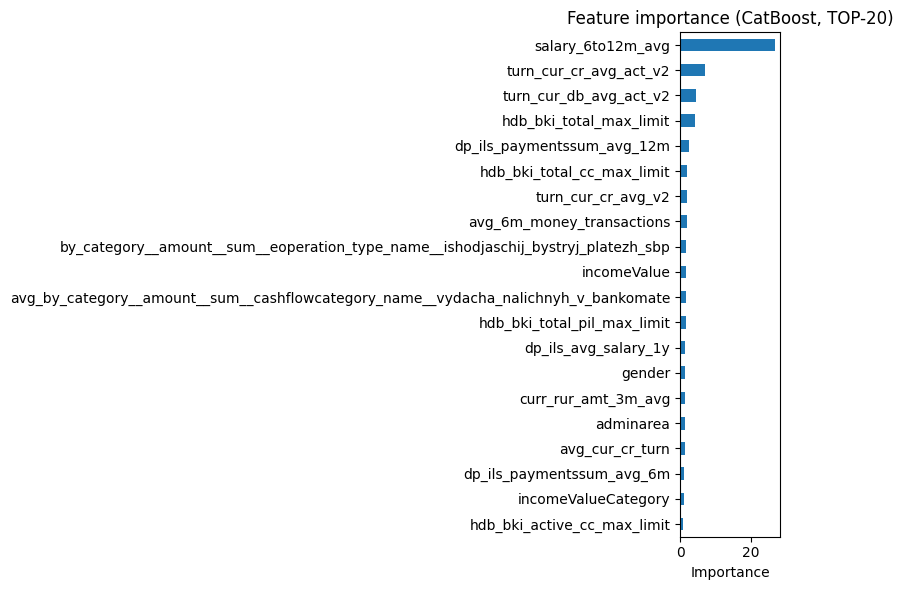

Фичи с высокой долей NaN и низкой важностью (кандидаты на удаление):


,feature,importance,na_share
173,calledCtnOutGroup,0.000000,0.845623
44,dp_ewb_last_employment_position,0.000000,0.803597
131,dp_ewb_dismissal_due_contract_violation_by_lb_cnt,0.000000,0.788907
169,dp_ils_days_ip_share_5y,0.000000,0.785404
170,hdb_bki_total_micro_max_overdue,0.000000,0.753679
217,transaction_category_supermarket_sum_cnt_d15,0.000000,0.545047
124,dp_ils_max_seniority,0.002576,0.783971



Всего кандидатов на дроп по этому критерию: 7
Дропаем кандидатов на удаление: 7
['calledCtnOutGroup', 'dp_ewb_last_employment_position', 'dp_ewb_dismissal_due_contract_violation_by_lb_cnt', 'dp_ils_days_ip_share_5y', 'hdb_bki_total_micro_max_overdue', 'transaction_category_supermarket_sum_cnt_d15', 'dp_ils_max_seniority']

Train shape после M3: (76786, 215)
Test shape после M3: (73214, 213)

После дропа мало важных фич:
Всего фичей: 212
Числовых фичей: 206
Категориальных фичей: 6
Найдено текстоподобных колонок: 0
[]
Текстовых колонок с подходящими характеристиками не найдено — текстовый EDA можно пропустить.


In [ ]:
# Индексы категориальных признаков для CatBoost
cat_idx = [X.columns.get_loc(c) for c in cat_features]

model_eda = CatBoostRegressor(
    depth=6,
    learning_rate=0.1,
    loss_function="MAE",   # близко к WMAE по смыслу
    random_seed=42,
    n_estimators=300,
    verbose=False
)

model_eda.fit(X, y, cat_features=cat_idx, sample_weight=w)

importances = model_eda.get_feature_importance()
fi = pd.Series(importances, index=X.columns).sort_values(ascending=False)

print("TOP-30 признаков по важности (CatBoost):")
display(fi.head(30))

# Визуализация TOP-20
top_k = 20
plt.figure(figsize=(8, 6))
fi.head(top_k).sort_values().plot(kind="barh")
plt.title(f"Feature importance (CatBoost, TOP-{top_k})")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Блок M2: фичи с высокой долей NaN и низкой важностью (кандидаты на дроп)

# доля NaN по текущим фичам
na_share = train[feature_cols].isna().mean()

fi_df = (
    pd.DataFrame({
        "feature": feature_cols,
        "importance": fi.reindex(feature_cols).fillna(0).values,
        "na_share": na_share.values,
    })
)

# пороги — можно настроить:
NA_THRESHOLD = 0.5      # "много пропусков"
IMP_THRESHOLD = fi_df["importance"].quantile(0.1)  # нижние 10% по важности

candidates = fi_df[
    (fi_df["na_share"] > NA_THRESHOLD) &
    (fi_df["importance"] <= IMP_THRESHOLD)
].sort_values(by=["importance", "na_share"], ascending=[True, False])

print("Фичи с высокой долей NaN и низкой важностью (кандидаты на удаление):")
display(candidates.head(50))

# если захочешь, можно сформировать список для дропа:
cols_to_maybe_drop_later = candidates["feature"].tolist()
print("\nВсего кандидатов на дроп по этому критерию:", len(cols_to_maybe_drop_later))

# Блок M3: финальный дроп "мало важных" фич с большой долей NaN

print("Дропаем кандидатов на удаление:", len(cols_to_maybe_drop_later))
print(cols_to_maybe_drop_later)

# служебные колонки
service_cols = [ID_COL, TARGET_COL, WEIGHT_COL]

# удаляем из train и test
train = train.drop(columns=cols_to_maybe_drop_later)
test  = test.drop(columns=cols_to_maybe_drop_later)

print("\nTrain shape после M3:", train.shape)
print("Test shape после M3:", test.shape)

# пересчитываем списки фичей и разбиение на num/cat
feature_cols = [c for c in train.columns if c not in service_cols]
num_features = train[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
cat_features = [c for c in feature_cols if c not in num_features]

print("\nПосле дропа мало важных фич:")
print("Всего фичей:", len(feature_cols))
print("Числовых фичей:", len(num_features))
print("Категориальных фичей:", len(cat_features))

# Блок EDA-8: поиск текстовых колонок и простое текстовое EDA

def detect_text_like_cols(df, cat_cols, min_avg_len=10, min_unique_ratio=0.1):
    text_cols = []
    for col in cat_cols:
        s = df[col].dropna().astype(str)
        if s.empty:
            continue
        avg_len = s.str.len().mean()
        uniq_ratio = s.nunique() / len(s)
        if avg_len >= min_avg_len and uniq_ratio >= min_unique_ratio:
            text_cols.append(col)
    return text_cols

text_like_cols = detect_text_like_cols(train, cat_features)
print("Найдено текстоподобных колонок:", len(text_like_cols))
print(text_like_cols)

if text_like_cols:
    text_col = text_like_cols[0]
    print("Проводим текстовый EDA по колонке:", text_col)

    s = train[text_col].dropna().astype(str)

    # Простейшая токенизация по пробелам
    all_words = " ".join(s.tolist()).lower().split()
    from collections import Counter
    word_counts = Counter(all_words)

    print("\nTOP-30 самых частых слов:")
    display(pd.DataFrame(word_counts.most_common(30), columns=["word", "count"]))

    # WordCloud (опционально)
    !pip install -q wordcloud
    from wordcloud import WordCloud

    text_sample = " ".join(s.sample(min(len(s), 5000), random_state=42).tolist())
    wc = WordCloud(width=800, height=400)
    wc.generate(text_sample)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"WordCloud для {text_col}")
    plt.tight_layout()
    plt.show()
else:
    print("Текстовых колонок с подходящими характеристиками не найдено — текстовый EDA можно пропустить.")


# Блок ML-1: импорты и метрика WMAE

In [ ]:
# Блок ML-1: импорты и метрика WMAE

import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

EPS = 1e-9

def smape(y_true, y_pred):
    """
    Symmetric MAPE: 2 * |y - ŷ| / (|y| + |ŷ|)
    """
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    denom = np.maximum(np.abs(y_true) + np.abs(y_pred), EPS)
    return np.mean(2.0 * np.abs(y_true - y_pred) / denom) * 100.0

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def wmae(y_true, y_pred, weights):
    """
    Weighted MAE = sum(w * |y - ŷ|) / sum(w)
    """
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    w = np.asarray(weights, float)
    return np.sum(w * np.abs(y_true - y_pred)) / np.sum(w)

def mape(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    denom = np.maximum(np.abs(y_true), EPS)
    return np.mean(np.abs(y_true - y_pred) / denom) * 100.0

def mdape(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    denom = np.maximum(np.abs(y_true), EPS)
    return np.median(np.abs(y_true - y_pred) / denom) * 100.0

def wmape(y_true, y_pred, weights=None):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    if weights is None:
        w = np.ones_like(y_true, float)
    else:
        w = np.asarray(weights, float)
    num = np.sum(w * np.abs(y_true - y_pred))
    den = np.sum(w * np.abs(y_true)) + EPS
    return num / den * 100.0

def wmpe(y_true, y_pred, weights=None):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    if weights is None:
        w = np.ones_like(y_true, float)
    else:
        w = np.asarray(weights, float)
    denom = np.maximum(np.abs(y_true), EPS)
    perc_err = (y_pred - y_true) / denom
    return np.sum(w * perc_err) / np.sum(w) * 100.0

def accuracy_at_thresholds(y_true, y_pred, thresholds=(0.1, 0.2, 0.3)):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    denom = np.maximum(np.abs(y_true), EPS)
    rel_err = np.abs(y_true - y_pred) / denom

    result = {}
    for t in thresholds:
        result[f"acc@{int(t*100)}%"] = float((rel_err < t).mean())
    return result

def rank_metrics(y_true, y_pred):
    # Используем numpy для скорости и стабильности
    # Корреляция Пирсона
    y_true_c = y_true - np.mean(y_true)
    y_pred_c = y_pred - np.mean(y_pred)
    denom = np.sqrt(np.sum(y_true_c**2) * np.sum(y_pred_c**2))
    if denom == 0:
        pearson = 0.0
    else:
        pearson = np.sum(y_true_c * y_pred_c) / denom

    # Спирмена лучше считать через pandas, но с обработкой ошибок
    try:
        s_true = pd.Series(y_true)
        s_pred = pd.Series(y_pred)
        spearman = s_true.corr(s_pred, method="spearman")
    except:
        spearman = 0.0

    return pearson, spearman



In [ ]:
# Блок M_corr: удаляем сильно коррелирующие числовые признаки (дубликаты)

corr_matrix = train[num_features].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

CORR_THRESH = 0.99
to_drop_corr = [col for col in upper.columns if any(upper[col] > CORR_THRESH)]

print("Дропаем сильно коррелирующие фичи:", len(to_drop_corr))
print(to_drop_corr)

train = train.drop(columns=to_drop_corr)
test  = test.drop(columns=to_drop_corr)

feature_cols = [c for c in train.columns if c not in [ID_COL, TARGET_COL, WEIGHT_COL, "period_last_act_ad"]]
num_features = train[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
cat_features = [c for c in feature_cols if c not in num_features]


Дропаем сильно коррелирующие фичи: 12
['turn_cur_cr_sum_v2', 'turn_cur_db_sum_v2', 'turn_cur_db_avg_act_v2', 'turn_cur_db_avg_v2', 'avg_cur_db_turn', 'turn_cur_db_min_v2', 'dp_payoutincomedata_payout_sum_3_month', 'mob_cover_days', 'turn_fdep_db_avg_v2', 'dp_ils_paymentssum_avg_6m_current', 'dp_ils_accpayment_avg_6m', 'hdb_other_active_max_psk']


In [ ]:
# Блок ML-2: формируем матрицу признаков и таргет

X = train[feature_cols].copy()
y_raw = train[TARGET_COL].copy()                 # таргет в рублях
w_raw = train[WEIGHT_COL].astype(float).copy()   # исходные веса из соревнования

# Таргет для обучения БЕЗ log
y = y_raw.copy()

# Веса модели = исходные веса (никакого time_weight)
w = w_raw.copy()

# Матрица признаков для test
X_test = test[feature_cols].copy()

# Категориальные признаки приводим к строке (как раньше)
for col in cat_features:
    X[col] = X[col].astype(str)
    X_test[col] = X_test[col].astype(str)

print("X shape:", X.shape)
print("X_test shape:", X_test.shape)
print("Target shape:", y.shape)

!pip install -q catboost
from catboost import CatBoostRegressor, Pool

# Блок ML-3: CatBoost и индексы категориальных признаков
cat_idx = [X.columns.get_loc(c) for c in cat_features]
print("Категориальных признаков:", len(cat_idx))


X shape: (76786, 199)
X_test shape: (73214, 199)
Target shape: (76786,)
Категориальных признаков: 5


In [ ]:
# Блок ML-4: KFold-валидация + CatBoost baseline БЕЗ log и без временных сплитов

N_FOLDS = 5
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

oof_pred = np.zeros(len(X))
fold_scores = []
fold_models = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y), 1):
    print(f"\n========== Fold {fold}/{N_FOLDS} ==========")

    X_tr, X_val = X.iloc[train_idx], X.iloc[valid_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[valid_idx]           # таргет в рублях

    # веса для обучения и валидации (только исходные w, без времени)
    w_tr, w_val = w.iloc[train_idx], w.iloc[valid_idx]

    # сырые веса для честной метрики WMAE
    y_val_raw = y_raw.iloc[valid_idx]
    w_val_raw = w_raw.iloc[valid_idx]

    train_pool = Pool(X_tr, y_tr, cat_features=cat_idx, weight=w_tr)
    valid_pool = Pool(X_val, y_val, cat_features=cat_idx, weight=w_val)

    model = CatBoostRegressor(
        depth=7,
        learning_rate=0.05,
        loss_function="MAE",
        eval_metric="MAE",
        random_seed=42,
        n_estimators=2000,
        od_type="Iter",
        od_wait=100,
        verbose=200
    )

    model.fit(train_pool, eval_set=valid_pool)

    # предсказания сразу в рублях
    val_pred = model.predict(X_val)
    oof_pred[valid_idx] = val_pred

    # качество на ФАКТИЧЕСКИХ весах хакатона
    fold_wmae = wmae(y_val_raw, val_pred, w_val_raw)

    fold_mape  = mape(y_val_raw, val_pred)
    fold_mdape = mdape(y_val_raw, val_pred)
    fold_wmape = wmape(y_val_raw, val_pred, w_val_raw)
    fold_wmpe  = wmpe(y_val_raw, val_pred, w_val_raw)

    acc_dict = accuracy_at_thresholds(y_val_raw, val_pred, thresholds=(0.1, 0.2, 0.3))
    pearson, spearman = rank_metrics(y_val_raw, val_pred)
    fold_r2 = r2_score(y_val_raw, val_pred)

    fold_scores.append(fold_wmae)

    print(f"Fold {fold} WMAE: {fold_wmae:.4f}")
    print(f"       MAPE: {fold_mape:.2f}%, MdAPE: {fold_mdape:.2f}%, "
          f"WMAPE: {fold_wmape:.2f}%, WMPE(bias): {fold_wmpe:.2f}%")
    print(f"       R2: {fold_r2:.4f}, Pearson: {pearson:.4f}, Spearman: {spearman:.4f}")
    print("       Accuracy:", ", ".join(f"{k}={v:.3f}" for k, v in acc_dict.items()))

    fold_models.append(model)

print("\n========== CV Results ==========")
print("Fold WMAE:", fold_scores)
print("Mean WMAE:", np.mean(fold_scores))
print("Std  WMAE:", np.std(fold_scores))

overall_wmae = wmae(y_raw, oof_pred, w_raw)
print("\nOverall OOF WMAE (на исходных весах):", overall_wmae)



========== Fold 1/5 ==========
0:	learn: 129278.3846147	test: 133456.1395192	best: 133456.1395192 (0)	total: 487ms	remaining: 16m 14s
200:	learn: 70743.1678386	test: 79974.0906931	best: 79974.0906931 (200)	total: 53.1s	remaining: 7m 55s
400:	learn: 64664.1003340	test: 76918.2442399	best: 76918.2442399 (400)	total: 1m 42s	remaining: 6m 50s
600:	learn: 61564.6347231	test: 76008.7701036	best: 76002.8066678 (598)	total: 2m 34s	remaining: 5m 58s
800:	learn: 59499.0037556	test: 75435.9345024	best: 75427.4286235 (796)	total: 3m 23s	remaining: 5m 5s
1000:	learn: 58132.8683826	test: 75050.4191708	best: 75050.4191708 (1000)	total: 4m 12s	remaining: 4m 12s
1200:	learn: 57021.8857251	test: 74776.0717863	best: 74776.0717863 (1200)	total: 5m 1s	remaining: 3m 20s
1400:	learn: 56007.2564955	test: 74559.1977416	best: 74559.1977416 (1400)	total: 5m 53s	remaining: 2m 31s
1600:	learn: 55220.4331500	test: 74406.1000739	best: 74404.9952514 (1587)	total: 6m 43s	remaining: 1m 40s
1800:	learn: 54489.6950351	t

In [ ]:
# === ML-5: Финальная модель на всех данных БЕЗ лог-таргета + логирование метрик ===

from datetime import datetime
import json
import joblib

MODEL_VERSION = "income_model_v3"

# === 5.1. CV-метрики по OOF-предсказаниям (в РУБЛЯХ) ===

oof_mae  = float(np.mean(np.abs(y_raw - oof_pred)))
oof_rmse = float(np.sqrt(np.mean((y_raw - oof_pred) ** 2)))
oof_r2   = float(r2_score(y_raw, oof_pred))
oof_wmae = float(wmae(y_raw, oof_pred, w_raw))

print("\n=== OOF CV metrics ===")
print(f"MAE:   {oof_mae:,.2f}")
print(f"RMSE:  {oof_rmse:,.2f}")
print(f"R2:    {oof_r2:.4f}")
print(f"WMAE:  {oof_wmae:,.2f}")

# === 5.2. Финальная модель на всех данных (таргет = рубли) ===

full_train_pool = Pool(X, y_raw, cat_features=cat_idx, weight=w)

final_model = CatBoostRegressor(
    depth=7,
    learning_rate=0.05,
    loss_function="MAE",
    eval_metric="MAE",
    random_seed=42,
    n_estimators=2000,
    od_type="Iter",
    od_wait=100,
    verbose=200,
)

final_model.fit(full_train_pool)

# Проверка качества на train (в рублях)
train_pred = final_model.predict(X)
train_wmae = float(wmae(y_raw, train_pred, w_raw))
print("Train WMAE (final_model):", train_wmae)

# === 5.3. Сабмит ===

sample_sub = pd.read_csv(DATA_DIR / "sample_submission.csv", sep=";")
test_pool = Pool(X_test, cat_features=cat_idx)
test_pred = final_model.predict(test_pool)

target_sub_col = [c for c in sample_sub.columns if c != ID_COL][0]

if (sample_sub[ID_COL].values == test[ID_COL].values).all():
    sample_sub[target_sub_col] = test_pred
else:
    df_pred = pd.DataFrame({ID_COL: test[ID_COL], target_sub_col: test_pred})
    sample_sub = sample_sub[[ID_COL]].merge(df_pred, on=ID_COL, how="left")

sub_path = DATA_DIR / "submission.csv"
sample_sub.to_csv(sub_path, index=False)
print("submission.csv сохранён в:", sub_path)

# === 5.4. Сохранение модели ===

MODELS_DIR = DATA_DIR / "models"
MODELS_DIR.mkdir(exist_ok=True)

model_path = MODELS_DIR / f"{MODEL_VERSION}.cbm"
final_model.save_model(model_path)
print("Модель сохранена в:", model_path)

# === 5.5. Логирование метрик ===

metrics_record = {
    "model_version": MODEL_VERSION,
    "trained_at": datetime.now().isoformat(timespec="seconds"),
    "train_samples": int(len(X)),
    "valid_samples": int(len(X)),
    "rmse": oof_rmse,
    "mae": oof_mae,
    "r2": oof_r2
}

metrics_path = MODELS_DIR / "training_metrics.json"
if metrics_path.exists():
    with open(metrics_path, "r") as f:
        metrics_history = json.load(f)
    if not isinstance(metrics_history, list):
        metrics_history = [metrics_history]
else:
    metrics_history = []

metrics_history.append(metrics_record)

with open(metrics_path, "w") as f:
    json.dump(metrics_history, f, indent=2, ensure_ascii=False)

print("training_metrics.json обновлён:", metrics_path)

# === 5.6. model_meta.json ===

meta = {
    "id_col": ID_COL,
    "target_col": TARGET_COL,
    "weight_col": WEIGHT_COL,
    "feature_cols": feature_cols,
    "cat_features": cat_features,
    "model_version": MODEL_VERSION,
    "n_features": len(feature_cols),
    "training_metrics": metrics_record,
}

meta_path = MODELS_DIR / "model_meta.json"
with open(meta_path, "w") as f:
    json.dump(meta, f, indent=2, ensure_ascii=False)

print("Мета-данные сохранены в:", meta_path)



=== OOF CV metrics ===
MAE:   33,117.79
RMSE:  72,252.77
R2:    0.5868
WMAE:  70,574.48
0:	learn: 130225.6938310	total: 265ms	remaining: 8m 50s
200:	learn: 71821.7020841	total: 58.8s	remaining: 8m 45s
400:	learn: 65990.4731481	total: 1m 53s	remaining: 7m 33s
600:	learn: 62923.7428004	total: 2m 49s	remaining: 6m 35s
800:	learn: 60974.4797215	total: 3m 45s	remaining: 5m 38s
1000:	learn: 59524.4410205	total: 4m 40s	remaining: 4m 39s
1200:	learn: 58446.7675842	total: 5m 35s	remaining: 3m 43s
1400:	learn: 57528.5442328	total: 6m 31s	remaining: 2m 47s
1600:	learn: 56789.4951282	total: 7m 25s	remaining: 1m 50s
1800:	learn: 55977.6515474	total: 8m 20s	remaining: 55.3s
1999:	learn: 55341.0286449	total: 9m 16s	remaining: 0us
Train WMAE (final_model): 55364.45964765692
submission.csv сохранён в: /content/drive/MyDrive/AlfaBand_HACK/submission.csv
Модель сохранена в: /content/drive/MyDrive/AlfaBand_HACK/models/income_model_v3.cbm
training_metrics.json обновлён: /content/drive/MyDrive/AlfaBand_HAC